In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
import seaborn as sns
from matplotlib import rcParams


# --- Setup Matplotlib for consistent font rendering ---
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'DejaVu Sans'
%matplotlib inline

In [2]:
deg = pd.read_csv("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Data/Daporinad_NAMPT_depMap_keyCluster_deg_optuna.csv")

In [3]:
print("--- Step 1: Loading and processing DEG results ---")

df = deg

# Rename gene column properly
df = df.rename(columns={"Unnamed: 0": "gene"})

# Drop rows with missing critical values (safety)
df = df.dropna(subset=["logFC", "P.Value", "adj.P.Val"])

# Compute -log10(p) safely (handles ultra-small p-values)
df["-log10p"] = -np.log10(df["P.Value"] + np.finfo(float).tiny)

# Define thresholds
padj_threshold = 0.05
logfc_threshold = 2.0

# Assign significance categories
conditions = [
    (df["logFC"] > logfc_threshold) & (df["adj.P.Val"] < padj_threshold),
    (df["logFC"] < -logfc_threshold) & (df["adj.P.Val"] < padj_threshold)
]
choices = ["Up-regulated", "Down-regulated"]

df["significance"] = np.select(
    conditions,
    choices,
    default="Not Significant"
)

print("Data processing complete.")


--- Step 1: Loading and processing DEG results ---
Data processing complete.


In [4]:
df

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,-log10p,significance
0,DNAH14,-3.712514,2.242108,-11.883910,1.340338e-29,2.183276e-25,55.989020,28.872786,Down-regulated
1,CRY1,-2.009733,4.484185,-10.886958,1.837192e-25,1.496301e-21,46.751763,24.735845,Down-regulated
2,KLF11,-2.537320,3.590351,-10.450715,9.949437e-24,5.402212e-20,42.882767,23.002202,Down-regulated
3,GPHN,-2.269347,4.092406,-9.952211,8.282346e-22,3.372778e-18,38.599142,21.081847,Down-regulated
4,ZNF74,-1.666681,3.745173,-9.774558,3.857722e-21,1.256769e-17,37.109302,20.413669,Not Significant
...,...,...,...,...,...,...,...,...,...
16284,SNORA16A,0.000054,-1.937511,0.000353,9.997185e-01,9.999640e-01,-6.540496,0.000122,Not Significant
16285,APPBP2.DT,-0.000046,-2.831604,-0.000269,9.997853e-01,9.999694e-01,-6.540496,0.000093,Not Significant
16286,WDR27,0.000021,4.577609,0.000184,9.998532e-01,9.999718e-01,-6.540496,0.000064,Not Significant
16287,HIGD1A,-0.000006,6.474387,-0.000059,9.999532e-01,9.999718e-01,-6.540497,0.000020,Not Significant


In [5]:
counts = df['significance'].value_counts()

upregulated = counts.get('Up-regulated', 0)
downregulated = counts.get('Down-regulated', 0)

print(f"Upregulated genes: {upregulated}")
print(f"Downregulated genes: {downregulated}")
print(f"Total DE genes: {upregulated + downregulated}")


Upregulated genes: 85
Downregulated genes: 111
Total DE genes: 196


In [6]:
deg_genes = df.loc[
    df['significance'].isin(['Up-regulated', 'Down-regulated']),
    'gene'
].tolist()
with open("Daporinad_NAMPT_DEG_up_down_sig_genes.txt", "w") as f:
    f.write("\n".join(deg_genes))


In [7]:
a

NameError: name 'a' is not defined

In [ ]:
df["abs_logFC"] = df["logFC"].abs()

genes_to_label = (
    df[df["significance"] != "Not Significant"]
    .sort_values(by=["adj.P.Val", "abs_logFC"], ascending=[True, False])
    .head(30)
)


--- Step 3: Generating the volcano plot ---


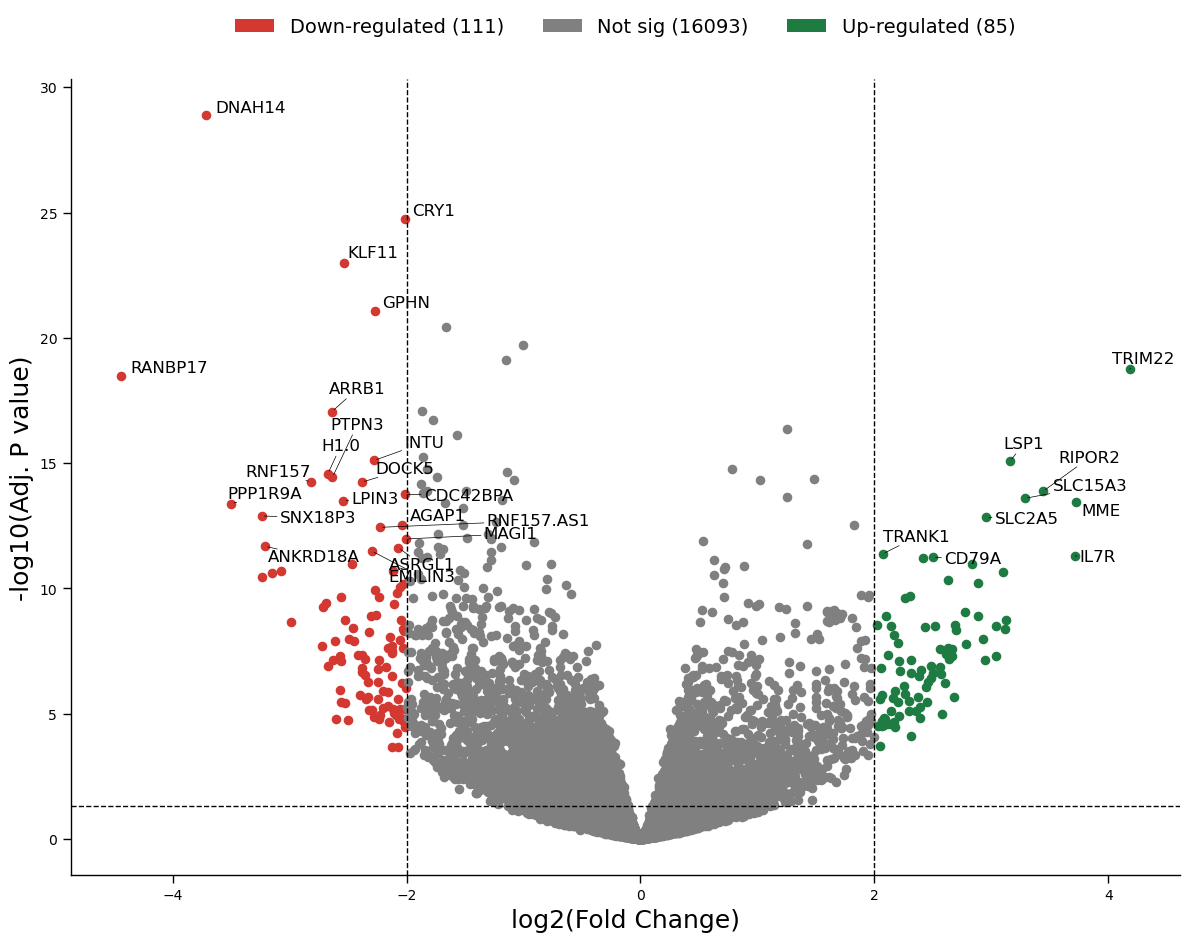

In [ ]:
# --- 4. Plotting ---
print("--- Step 3: Generating the volcano plot ---")


# Define colors and create dynamic legend labels
#color_map = {'Up-regulated': "#f56e30", 'Down-regulated': '#00bfc4', 'Not Significant': 'grey'}
color_map = {'Up-regulated': "#1e7c43", 'Down-regulated': '#d33831', 'Not Significant': 'grey'}
counts = df['significance'].value_counts()
legend_labels = {
    'Down-regulated': f"Down-regulated ({counts.get('Down-regulated', 0)})",
    'Not Significant': f"Not sig ({counts.get('Not Significant', 0)})",
    'Up-regulated': f"Up-regulated ({counts.get('Up-regulated', 0)})"
}

fig, ax = plt.subplots(figsize=(12, 10))  # Width=8 inches, Height=6 inches


# Plot points for each group (ALL rasterized)
for sig_type, color in color_map.items():
    subset = df[df['significance'] == sig_type]
    ax.scatter(subset['logFC'], subset['-log10p'], color=color, alpha=1, s=35, rasterized=True)


# --- 5. Add Annotations and Customize Aesthetics ---
# Add gene labels using adjustText to prevent overlap
texts = [ax.text(row['logFC'], row['-log10p'], row['gene'], color='black', fontsize=12)
         for i, row in genes_to_label.iterrows()]
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
            force_text=(0.1, 0.5))

# Add threshold lines
ax.axvline(x=-logfc_threshold, linestyle='--', color='black', lw=1)
ax.axvline(x=logfc_threshold, linestyle='--', color='black', lw=1)
ax.axhline(y=-np.log10(padj_threshold), linestyle='--', color='black', lw=1)

# Set labels
ax.set_xlabel('log2(Fold Change)', fontsize=18)
ax.set_ylabel('-log10(Adj. P value)', fontsize=18)


# Create a custom legend
#legend_elements = [Patch(facecolor=c, label=l) for c, l in zip(color_map.values(), legend_labels.values())]

# Make sure this order matches the plotting order

# Explicitly define the order
ordered_labels = ['Down-regulated', 'Not Significant', 'Up-regulated']

# Build legend elements correctly
legend_elements = [
    Patch(facecolor=color_map[label], label=legend_labels[label])
    for label in ordered_labels
]

#legend_elements = [Patch(facecolor=color_map[key], label=f"{legend_labels[key]} ({counts[key]})")
#                   for key in color_map]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, frameon=False, fontsize=14)

# --- FIX #3 (PLOTTING): Remove manual ylim setting to prevent label clipping ---
# Let matplotlib and adjust_text automatically set the limits to ensure all labels are visible.
# plt.ylim(0, df['-log10p'].max() * 1.1) <-- REMOVED THIS LINE

# Clean up the plot aesthetics
ax.grid(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(1)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='both', which='both', width=1,length=6, direction='out')

# --- 6. Save and Show the Plot ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/Daporinad_volcano_plot.pdf", dpi=600, bbox_inches='tight')

#print(f"\nDebugged volcano plot saved to: {output_plot_path}")
plt.show()